# <font color= 'blue'> Project: High Value Customer Identification (Insiders)</font>


## Business Challange

A loyalty program of customers to increase sales frquency.

## Business Planning (IOT)

### Input 
    1. Business Problem
        - Select the most valuable customers to join a loyalty program.
    
    2. Dataset
        - One year e-commerce sales.
        Invoice No: Invoice number (A 6-digit integral number uniquely assigned to each transaction)

        Stock Code: Product (item) code

        Description: Product (item) name

        Quantity: The quantities of each product (item) per transaction

        Invoice Date: The day when each transaction was generated

        Unit Price: Unit price (Product price per unit)

        Customer ID: Customer number (Unique ID assigned to each customer)

        Country: Country name (The name of the country where each customer resides)
    
### Output
    1. Indicate customers who will be part of a loyalty program called Insiders.
            - List: client_id | is_insider
                        10323 |   yes
                        32413 |   no
    2. A report with the answers for the business questions.
    - Who are the customers eligible to join the program?
    - How many customers will be part os this group?
    - What are the main characteristics of these customers?
    - What is the contribution percentage revenue from Insiders?
    - What is the group's revenue expectation for the coming months?
    - What are the condictions for select customers to join Insiders?
    - What are the condictions for removing Insiders customers?
    - What is the guarantee that the Insiders program is better than the rest of the base?
    - What actions can the marketing team take to increase revenue?
    
### Taks
    1. Who are the customers eligible to join the program?
        - What does it mean, to be elegible? What does high-value customers mean?
             - Revenue: ticket, bascket size, high LTV (Lifetime Value), churn probability,high TVC prevision, purchasing propensity.
             - Cost: lower return rate.
             - Purchase experience: high average evaluation rate.
     
    2. How many customers will be part os this group?
        - Total nambers of customers.
        - % Insiders group.
        
    3. What are the main characteristics of these customers?
        - Age
        - Location
        - Others characteristics.
        - Ticket, bascket size, high LTV, churn probability,high TVC prevision, purchasing propensity.
        
    4. What is the contribution percentage revenue from Insiders?
         - Total revenue for the year.
         - Insiders group revenue.
         
    5. What is the group's revenue expectation for the coming months?
        - LTV Insisders group.
        - Cohort analysis.
        
    6. What are the condictions for select customers to join Insiders?
        - Define the periodicity
        - The person needs to have similar characteristics with someone in the group.
    
    7. What are the condictions for removing Insiders customers?
        - Define the periodicity
        - The person doen't need to have similar characteristics with someone in the group.
        
    8. What is the guarantee that the Insiders program is better than the rest of the base?
        - A/B test
        - A/B bayesian test
        - Hypothesis test
        
    9. What actions can the marketing team take to increase revenue?
        - Discont
        - Purchase preference
        - Purchase shipping
        - Company visit  
        
## Benchmark Solutions

###  Desk Research
 - RFM model (recency, frequency,, monetary): sorted data to have a RFM Score.
 
     Recency: How recently a customer has made a purchase
     
     Frequency: How often a customer makes a purchase
     
     Monetary Value: How much money a customer spends on purchases
     

 - example project: https://guillaume-martin.github.io/rfm-segmentation-with-python.html

# 0.0. Imports

In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import umap.umap_ as umap

from pandas_profiling import ProfileReport

from matplotlib import pyplot as plt
from IPython.display import Image, HTML
from datetime import datetime
from sklearn import cluster as c
from sklearn import metrics as m
from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1. Helper Functions

In [115]:
 def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings() 
    

Populating the interactive namespace from numpy and matplotlib


/Users/anaotavio/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2. Load dataset

In [116]:
# load data
df_raw = pd.read_csv('/Users/anaotavio/Documents/repos/insiders_clustering//data/Ecommerce.csv')

# drop extra column
df_raw = df_raw.drop(columns = ['Unnamed: 8'], axis = 1)

# 1.0. Data Description

In [117]:
df1 = df_raw.copy()

## 1.1. Rename columns

In [118]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2. Data dimensions

In [119]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 541909
Number of Columns: 8


## 1.3. Data types

In [120]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [121]:
df1['invoice_no'] = df1['invoice_no'].astype(int)

ValueError: invalid literal for int() with base 10: 'C536379'

In [122]:
df1['stock_code'] = df1['stock_code'].astype(int)

ValueError: invalid literal for int() with base 10: '85123A'

## 1.4. Check NA

In [123]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [124]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

In [125]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on = 'invoice_no', how= 'left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x','customer_id_y'], axis=1)
   
df1.head()    


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [126]:
# No NaN in 'customer_id'
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6. Change dtypes

In [127]:
# invoice_date
df1["invoice_date"] = pd.to_datetime(df1["invoice_date"],infer_datetime_format=True)

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7. Descriptive Statistics

In [128]:
num_attributes = df1.select_dtypes(include =['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

In [129]:
 # central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'mediana', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,mediana,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


#### 1.7.1.1. Numerical Attributes - Investigating

1. Could be negative quantity, return?
2. Unit price = 0. Could it be sales?


### 1.7.2. Categorical Attributes

#### Invoice number

In [130]:
#cat_attributes['invoice_no'].astype(int)  -> Data contains 'invoice_no' with numbers and letters.
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search( '[^0-9]+', x ))), :]
len(df_letter_invoices)

print('Total number of invoices:{}'.format(len(df_letter_invoices)))
print('Total number os negative quantity:{}'.format(len(df_letter_invoices[df_letter_invoices['quantity']< 0])))

Total number of invoices:9291
Total number os negative quantity:9288


#### Stock Code

In [131]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

# Action:
## 1. Remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Description

In [132]:
# Action: Delete description

#### Country

In [133]:
len(df1['country'].unique())

38

In [134]:
df1['country'].value_counts(normalize = True).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [135]:
df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending = False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0. Data Filtering

In [136]:
df2 = df1.copy()

In [137]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [138]:
# === Numerical attributes ====
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop( columns='description', axis=1 )

# map -  
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# bad users
#df2 = df2[~df2['customer_id'].isin( [16446] )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchase = df2.loc[df1['quantity'] >= 0, :]

# 3.0. Feature Engineering

In [139]:
df3 = df2.copy()

In [140]:
# Feature Ideas:
## 1) Moving Average - 7d, 14d, 30d
## 2) Purchase quantity by month, before the 15th and after the 15th.
## 3) Average Financial

## 3.1. Feature Creation

In [141]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'],
                   axis =1 ).drop_duplicates( ignore_index = True)

### 3.1.1. Gross Revenue

In [142]:
# Gross Revenue
df2_purchase.loc[:,'gross_revenue'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unit_price']

# Monetary
df_monetary = df2_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id', how = 'left')
df_ref.isna().sum()

/Users/anaotavio/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/anaotavio/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency - Day from last purchase

In [143]:
 # Recency - Last day purchase
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Quantity of purchased

In [144]:
# Frequency - It depens on product returns
df_freq =(df2_purchase.loc[:,['customer_id', 'invoice_no']].drop_duplicates()
                                                          .groupby('customer_id')
                                                          .count()
                                                          .reset_index()
                                                          .rename(columns={'invoice_no': 'quantity_invoices'}))
df_ref = pd.merge( df_ref, df_freq, on = 'customer_id', how ='left')
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_invoices    91
dtype: int64

### 3.1.4. Quantity of items purchased

In [145]:
df_freq = (df2_purchase.loc[:,['customer_id', 'quantity']].groupby('customer_id')
                                                        .sum()
                                                        .reset_index()
                                                        .rename(columns={'quantity': 'quantity_items'}))
                                                        
                                                        
df_ref = pd.merge( df_ref, df_freq, on = 'customer_id', how ='left')
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_invoices    91
quantity_items       91
dtype: int64

### 3.1.5. Quantity of products purchased

In [146]:
df_freq = (df2_purchase.loc[:,['customer_id', 'stock_code']].groupby('customer_id')
                                                        .count()
                                                        .reset_index()
                                                        .rename(columns={'stock_code': 'quantity_products'}))
                                                        
                                                        
df_ref = pd.merge( df_ref, df_freq, on = 'customer_id', how ='left')
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_invoices    91
quantity_items       91
quantity_products    91
dtype: int64

### 3 .1.6. Average Ticket Value

In [147]:
# Average Ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_invoices    91
quantity_items       91
quantity_products    91
avg_ticket           91
dtype: int64

### 3.1.7. Average Recency Days

In [148]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=['False', 'False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] ==x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
quantity_invoices      91
quantity_items         91
quantity_products      91
avg_ticket             91
avg_recency_days     2816
dtype: int64

### 3.1.8. Frequency Purchase

In [149]:
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
quantity_invoices      91
quantity_items         91
quantity_products      91
avg_ticket             91
avg_recency_days     2816
frequency              91
dtype: int64

### 3.1.9. Number of Returns

In [150]:
df2_returns.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
154,C536383,35004C,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,-24,2016-11-29,0.29,United Kingdom,17548
238,C536391,21980,-24,2016-11-29,0.29,United Kingdom,17548


In [151]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'quantity_returns'} )


In [152]:
df_returns['quantity_returns'] = df_returns['quantity_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['quantity_returns'].isna(), 'quantity_returns'] = 0

df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
quantity_invoices      91
quantity_items         91
quantity_products      91
avg_ticket             91
avg_recency_days     2816
frequency              91
quantity_returns        0
dtype: int64

### 3.2.0. Basket Size - Quantity items per basket

- Invoice No = purchase
- Stock Code = product
- Quantity = Item

In [153]:
df_aux = (df2_purchase.loc[:,['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                           .agg(n_purchase=('invoice_no', 'nunique'),
                                                                n_products=('quantity', 'sum'))
                                                            .reset_index())
# calculation
df_aux['avg_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
quantity_invoices      91
quantity_items         91
quantity_products      91
avg_ticket             91
avg_recency_days     2816
frequency              91
quantity_returns        0
avg_basket_size        91
dtype: int64

### 3.2.1. Unique Basket Size - Quantity of differents products per purchase

- Invoice No = purchase
- Stock Code = product
- Quantity = Item

In [154]:
df_aux = (df2_purchase.loc[:,['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                           .agg(n_purchase=('invoice_no', 'nunique'),
                                                                n_products=('stock_code', 'count'))
                                                            .reset_index())
# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products']/df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
quantity_invoices           91
quantity_items              91
quantity_products           91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
quantity_returns             0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [155]:
df_ref.head()

,customer_id,gross_revenue,recency_days,quantity_invoices,quantity_items,quantity_products,avg_ticket,avg_recency_days,frequency,quantity_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,8.735294
1,13047,3232.59,56.0,9.0,1390.0,171.0,18.904035,27.250000,0.028302,35.0,154.444444,19.000000
2,12583,6705.38,2.0,15.0,5028.0,232.0,28.902500,23.187500,0.040323,50.0,335.200000,15.466667
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,1.000000


# 4.0. Exploratory Data Analysis (EDA)

In [156]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
quantity_invoices         0
quantity_items            0
quantity_products         0
avg_ticket                0
avg_recency_days          0
frequency                 0
quantity_returns          0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1. Univariate Analysis

In [113]:
#from pandas_profiling import ProfileReport
profile = ProfileReport (df4)
profile.to_file('output.html')

# to visualize: file:///Users/anaotavio/Documents/repos/insiders_clustering/notebook/output.html

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [157]:
df4.sort_values('gross_revenue', ascending=False).drop_duplicates().head(10)

,customer_id,gross_revenue,recency_days,quantity_invoices,quantity_items,quantity_products,avg_ticket,avg_recency_days,frequency,quantity_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,72.0,196844.0,2060.0,135.503893,7.844444,0.203390,288.0,2733.944444,28.611111
492,18102,259657.30,0.0,60.0,64124.0,431.0,602.453132,14.680000,0.163043,0.0,1068.733333,7.183333
433,17450,194550.79,8.0,46.0,69993.0,337.0,577.302047,12.821429,0.127778,952.0,1521.586957,7.326087
3338,16446,168472.50,0.0,2.0,80997.0,3.0,56157.500000,205.000000,0.009709,80995.0,40498.500000,1.500000
66,14911,140450.72,1.0,199.0,80263.0,5673.0,24.757751,2.601399,0.533512,3332.0,403.331658,28.507538
1150,12415,124564.53,24.0,20.0,77373.0,713.0,174.704811,20.866667,0.063694,427.0,3868.650000,35.650000
190,14156,117379.63,9.0,55.0,57885.0,1400.0,83.842593,7.260000,0.151515,859.0,1052.454545,25.454545
15,17511,91062.38,2.0,31.0,64549.0,963.0,94.561142,11.593750,0.083333,1535.0,2082.225806,31.064516
12,16029,72882.09,38.0,62.0,40207.0,241.0,302.415311,9.054054,0.184524,8004.0,648.500000,3.887097
955,16684,66653.56,4.0,28.0,50255.0,277.0,240.626570,22.125000,0.078873,864.0,1794.821429,9.892857


## 4.2. Bivariate Analysis

# 5.0. Data Preparation

In [92]:
df5 = df4.copy()

In [93]:
from sklearn import preprocessing as pp

In [94]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])


In [95]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,quantity,avg_ticket,avg_recency_days,frequency
0,17850,-0.185926,6.392712,0.493163,6.0,-0.234004,1.0,0.486111
1,17850,-0.185926,6.392712,0.493163,6.0,-0.234004,70.0,0.486111
2,13047,-0.263093,-0.038890,-0.272188,12.0,-0.226355,36.0,0.048780
3,13047,-0.263093,-0.038890,-0.272188,12.0,-0.226355,28.0,0.048780
4,13047,-0.263093,-0.038890,-0.272188,12.0,-0.226355,55.0,0.048780


# 6.0. Feature Selection

In [96]:
df6 = df5.copy()

/Users/anaotavio/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/anaotavio/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


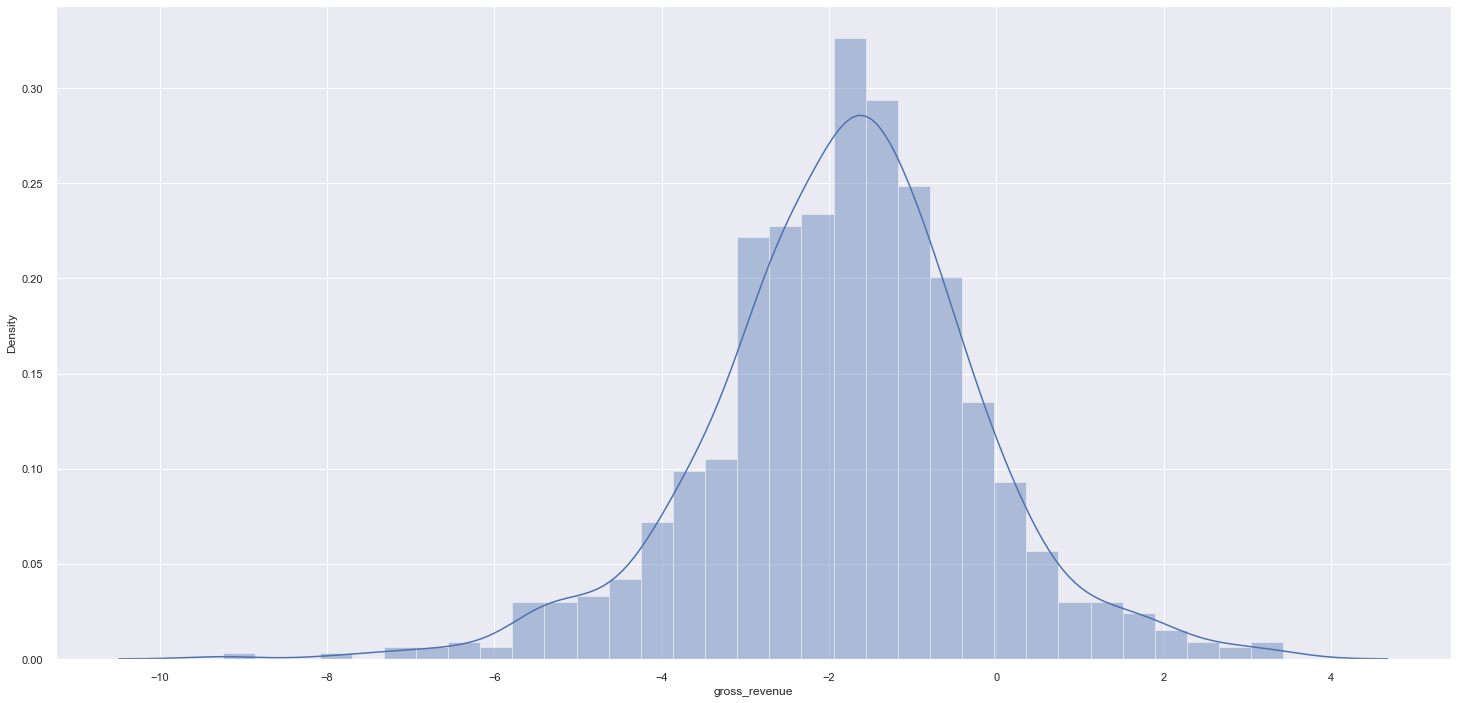

In [198]:
sns.distplot(np.log(df5['gross_revenue']))

# 7.0. Hyperparameter Fine Tunning

In [199]:
X = df6.drop(columns = ['customer_id'])

In [200]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.370775,2.798137,3.858949,-0.033857
1,0.131350,-0.609622,0.743157,-0.033401
2,0.580906,-0.899432,1.392280,-0.026143
3,-0.123151,0.029957,0.094034,-0.023154
4,-0.131183,2.408394,-0.165616,0.152610


In [201]:
clusters = [2, 3, 4, 5, 6, 7]

## 7.1. Within-Cluster Sum os Square (WSS)

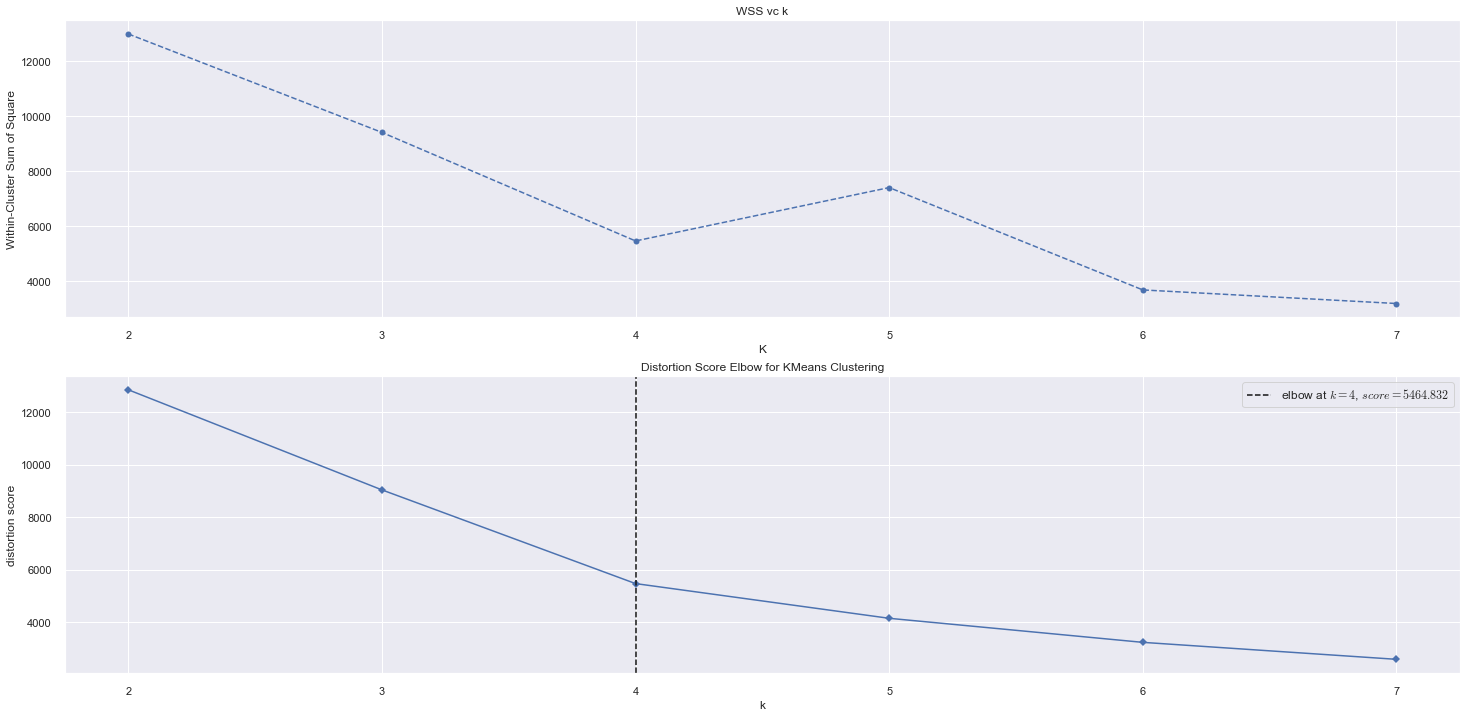

In [202]:
# WSS: Within- CLuster Sum of Squares -> compactness
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    # model training
    kmeans.fit(X)
    
    # validation
    wss.append(kmeans.inertia_)
    

plt.subplot(2, 1, 1 )
# Plot wss - Elbow Method
plt.plot(clusters, wss, linestyle='--', marker = 'o', color='b')
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vc k')

plt.subplot(2, 1, 2 )
#from yellowbrick.cluster import KElbowVisualizer
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False)
kmeans.fit( X)
kmeans.show()

plt.show()

## 7.2. Silhouette Score

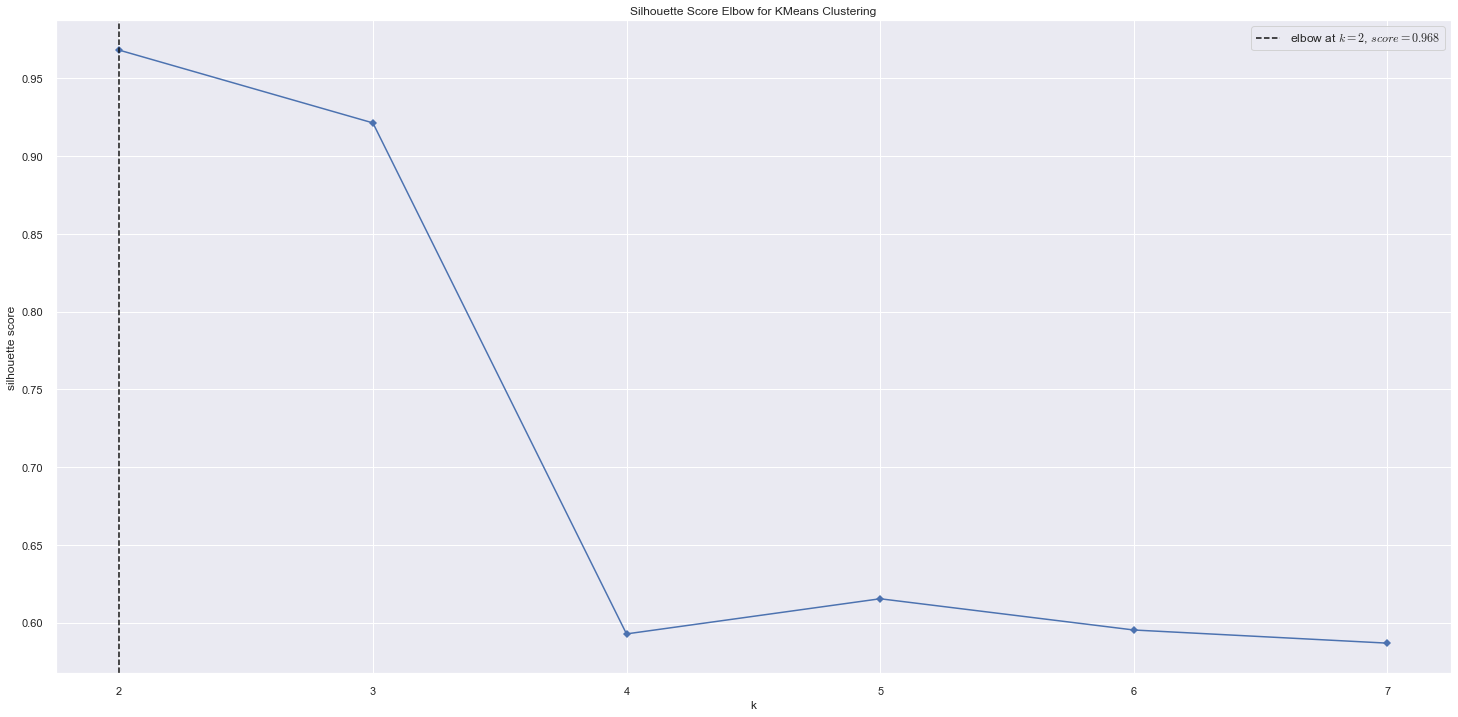

In [203]:
# Silhoutte Score: is calculated using the mean intra-cluster distance ( a ) and the mean nearest-cluster distance ( b ) for each sample
# Is about separation
# Silhouette is better than Wss because takes into consideration the nearest-cluster distance.

kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit( X)
kmeans.show()


## 7.1. Silhouette Analysis

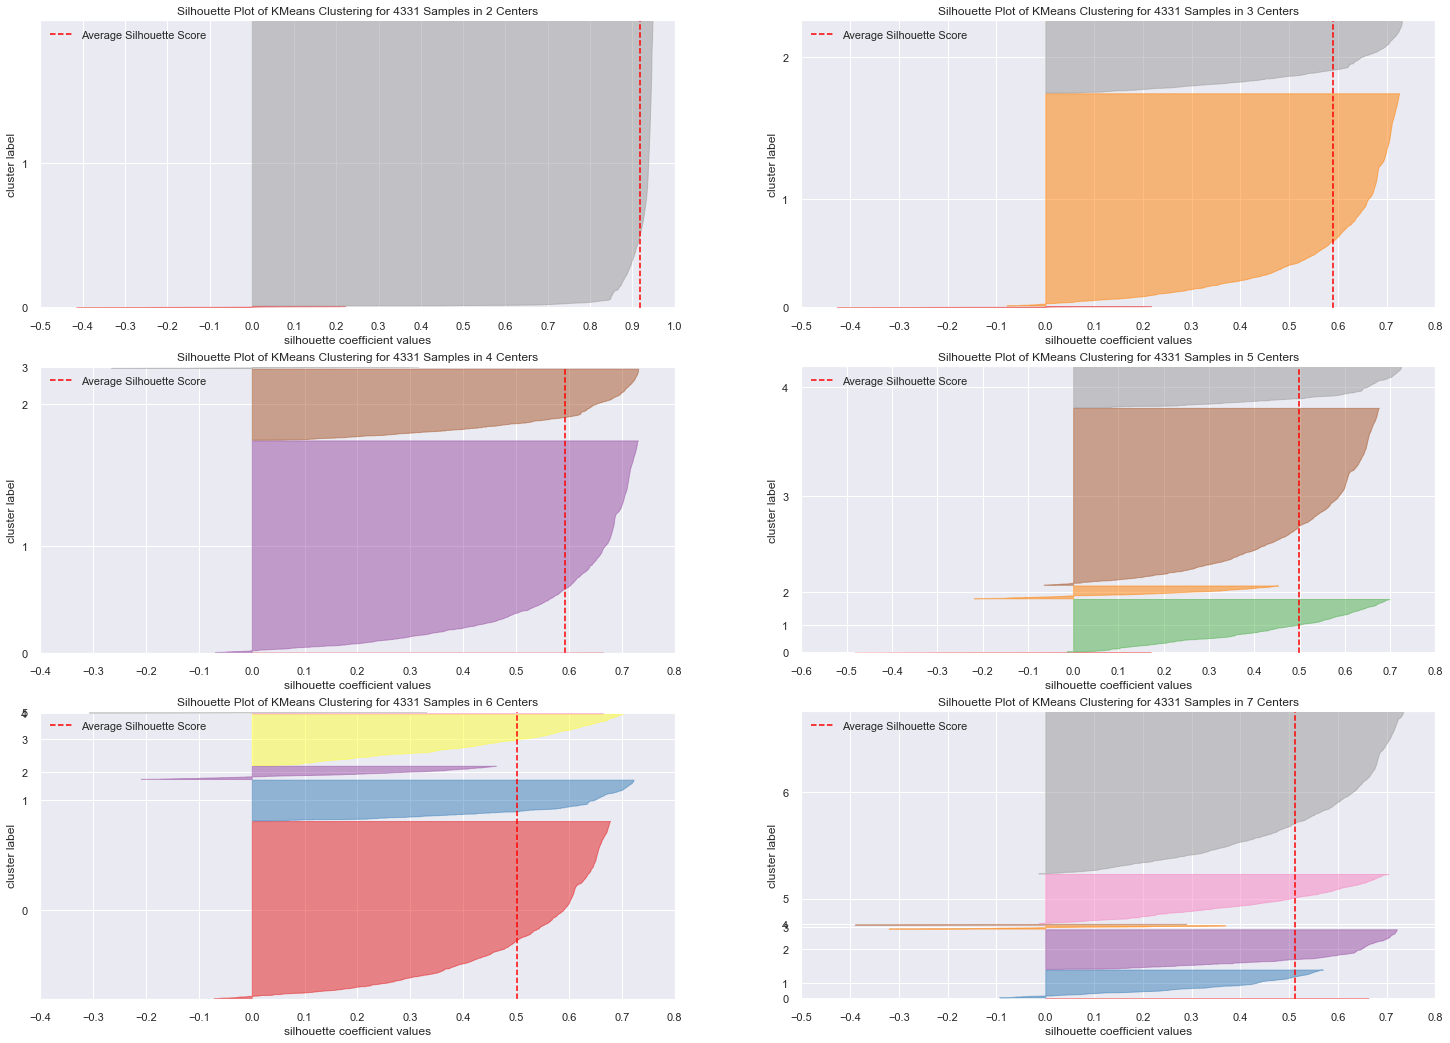

In [204]:
# from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
k=3
fig, ax = plt.subplots(3,2, figsize=(25,18))
for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, colosr='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0. Model Training

## 8.1. K-Means

In [205]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2. Cluster Validation

In [206]:
# WSS (Within- cluster sum of square)
print('WSS value: {}'.format( kmeans.inertia_))

from sklearn import metrics as m
# SS (Silhouette Score)
print('SS value: {}'.format (m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 9306.48353575122
SS value: 0.583140863579508


# 9.0. Cluster Analysis

In [207]:
df9 = df6.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850,0.370775,2.798137,3.858949,-0.033857,2
1,13047,0.131350,-0.609622,0.743157,-0.033401,0
2,12583,0.580906,-0.899432,1.392280,-0.026143,0
3,13748,-0.123151,0.029957,0.094034,-0.023154,0
4,15100,-0.131183,2.408394,-0.165616,0.152610,2


## 9.1. Visualization Inspection

NameError: name 'viausalizer' is not defined

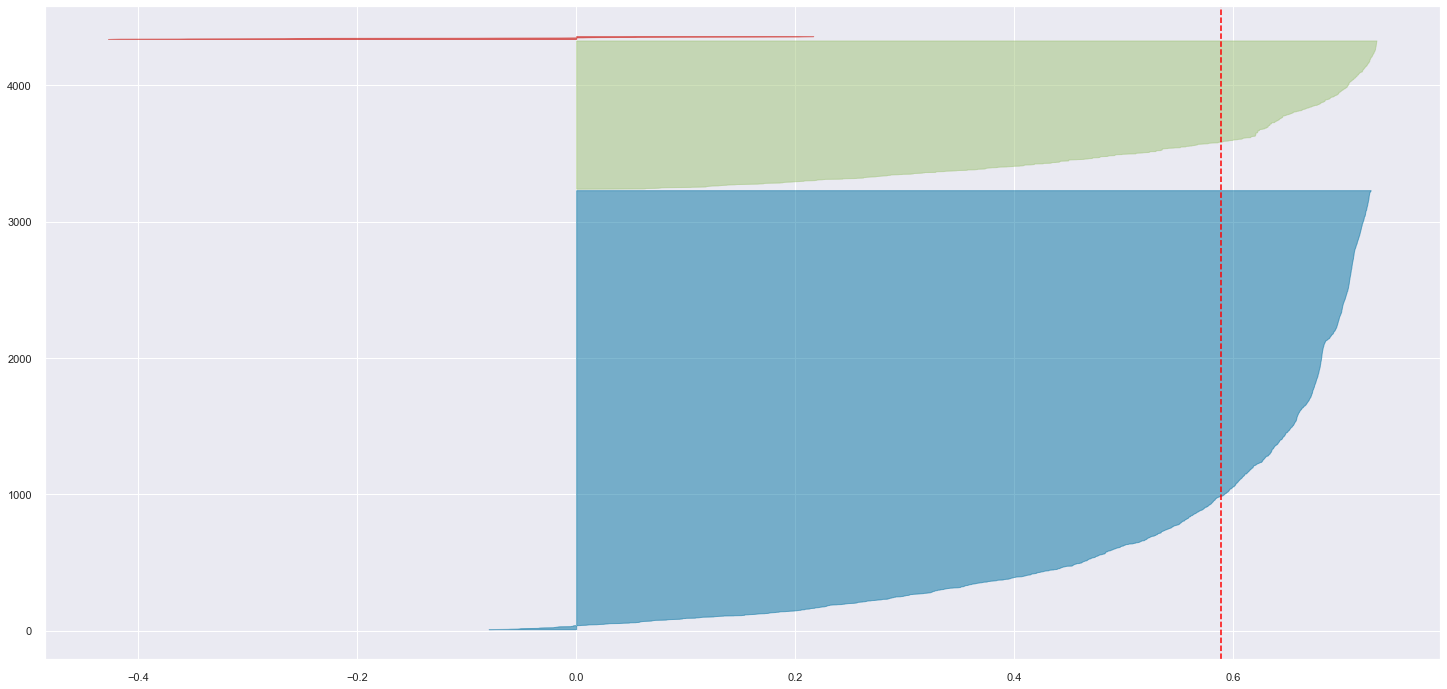

In [176]:
#from plotly import express as px
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
#fig.show()

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
viausalizer.finalize()

## 9.2. 2d plot

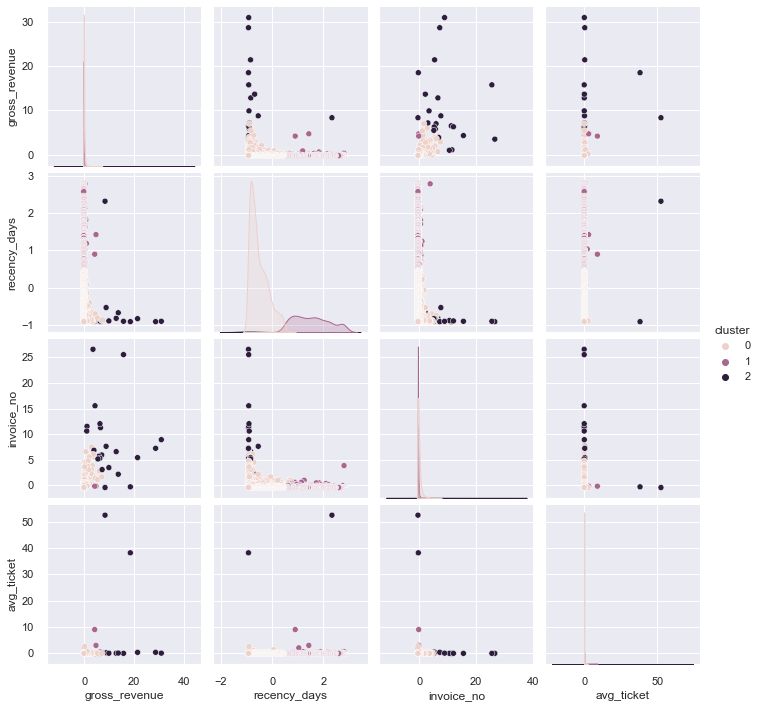

In [177]:
df_viz = df9.drop( columns = 'customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.4. UMAP -t-SNE


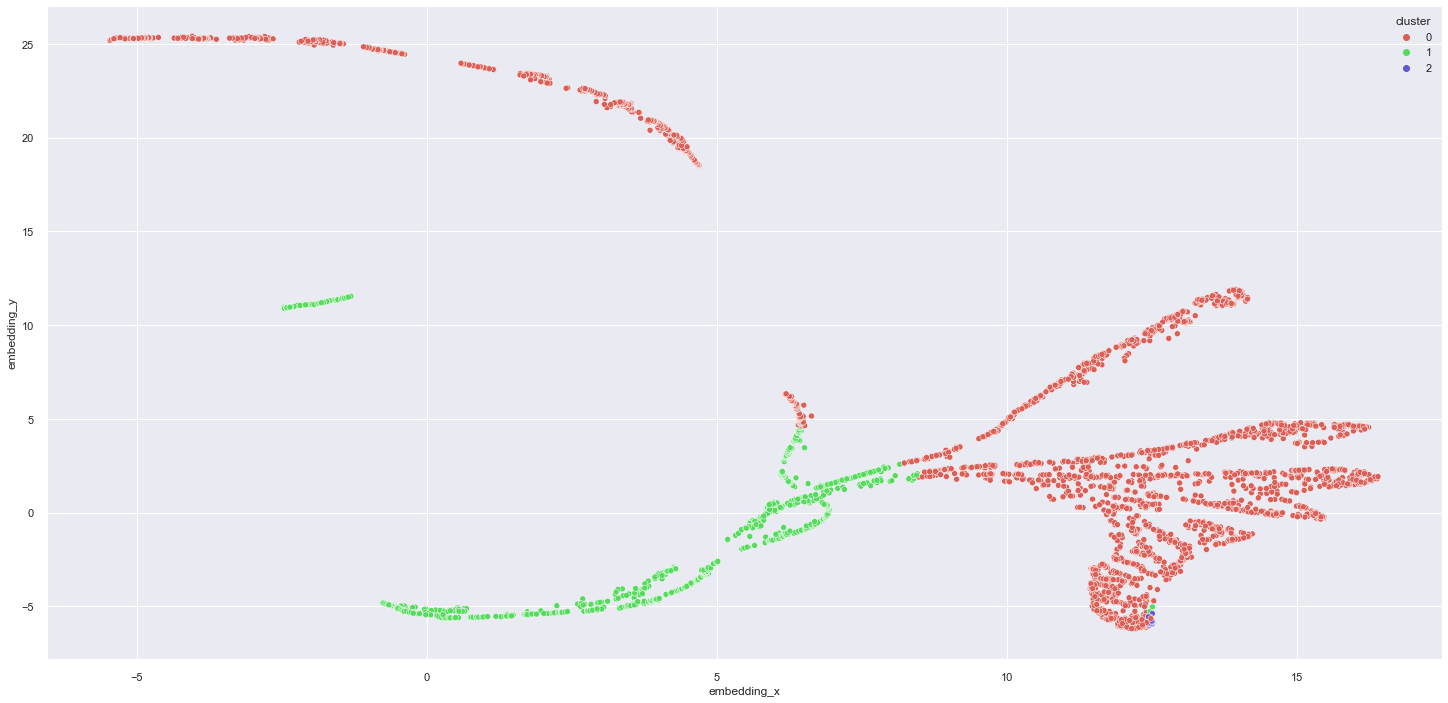

In [178]:
#!pip install llvmlite==0.37.0rc2 --ignore-installed
#!pip install umap-learn
#import umap.umap_ as umap

# UMAP: cluster designed with high dimensionality

reducer = umap.UMAP(n_neighbors=90, random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
                hue='cluster',
                palette=sns.color_palette('hls',
                                          n_colors=len(
                                              df_viz['cluster'].unique())),
                data=df_viz)

## 9.2. Profil de grappe

In [208]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())

# Avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how = 'inner', on ='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how = 'inner', on ='cluster')

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how = 'inner', on ='cluster')

# Avg ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how = 'inner', on ='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,3227,74.509351,-0.002545,-0.515841,0.077257,-0.024764
1,1,14,0.323251,13.529129,-0.626040,9.404318,6.541111
2,2,1090,25.167398,-0.166235,1.535215,-0.349514,-0.010700


**Cluster 1: Insider Candidate**
- Number of customers: 6 (0,14% of customers)
- Average Recency: 7 days
- Average Purchase: 89 
- Avarage Revenue: $ 182.182,00 dollars
- Avarage Ticket: $ 253,62

**Cluster 0:**
- Number of customers: 28 (0,64% of customers)
- Average Recency: 6 days
- Average Purchase: 57 
- Avarage Revenue: $ 42.614,38 dollars  
- Avarage Ticket: $ 162,86

    
**Cluster 3:**
- Number of customers: 269 (6,15% of customers)
- Average Recency: 20 days
- Average Purchase: 19 
- Avarage Revenue: $ 944, 95 dollars
- Avarage Ticket: $ 62,47


**Cluster 2:**
- Number of customers: 4069 (93,06% of customers)
- Average Recency: 92 days
- Average Purchase: 4 
- Avarage Revenue: $ 1.372,57 dollars  
- Avarage Ticket: $ 25.36

# 10.0. Deploy to Production